In [1]:
import itertools
import pandas
import numpy
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer

from joblib import dump, load

import seaborn
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Context

In this notebook we experiment with some model stacking / averaging techniques.

### Load data

In [2]:
X_train = pandas.read_csv("../data/split/X_train.csv", index_col="Id")
X_test = pandas.read_csv("../data/split/X_test.csv", index_col="Id")
y_train = pandas.read_csv("../data/split/y_train.csv", index_col="Id")["SalePrice"]
y_test = pandas.read_csv("../data/split/y_test.csv", index_col="Id")["SalePrice"]

### Load models

Re-instantiate locally defined methods

In [3]:
def add_boolean_features(df):
    return (
        df
        .assign(
            HasPool=lambda x: numpy.where(x["PoolArea"] > 0, 1, 0),
            Has2ndFloor=lambda x: numpy.where(x["2ndFlrSF"] > 0, 1, 0),
            HasGarage=lambda x: numpy.where(x["GarageArea"] > 0, 1, 0),
            HasBasement=lambda x: numpy.where(x["TotalBsmtSF"] > 0, 1, 0),
            HasFireplace=lambda x: numpy.where(x["Fireplaces"] > 0, 1, 0),
            HasBeenRemodelled=lambda x: numpy.where(x["YearBuilt"] == x["YearRemodAdd"], 1, 0),
        )
    )

def add_boolean_feature_names(self, input_features):
    return numpy.hstack([
        input_features,
        ["HasPool", "Has2ndFloor", "HasGarage", "HasBasement", "HasFireplace", "HasBeenRemodelled"]
    ])

def add_total_sf_features(df):
    return (
        df
        .assign(
            TotalSF=lambda x: x["TotalBsmtSF"] + x["1stFlrSF"] + x["2ndFlrSF"],
            TotalBathrooms=lambda x: x["FullBath"] + 0.5 * x["HalfBath"] + x["BsmtFullBath"] + 0.5 * x["BsmtHalfBath"],
            TotalPorchSF=lambda x: x["OpenPorchSF"] + x["3SsnPorch"] + x["EnclosedPorch"] + x["ScreenPorch"] + x["WoodDeckSF"],
            BuildingAge=lambda x: x["YrSold"] - x["YearRemodAdd"],
        )
    )

def add_total_sf_feature_names(self, input_features):
    return numpy.hstack([
        input_features,
        ["TotalSF", "TotalBathrooms", "TotalPorchSF", "BuildingAge"]
    ])

def add_neighborhood_features(df):

    nghd_scores = (
        df
        .groupby(by=["Neighborhood"])
        .agg({"OverallQual": "mean"})
        .sort_values(by=["OverallQual"], ascending=False)
    )

    return (
        df
        .assign(
            NeighborhoodQual=lambda x: numpy.select(
                [x["Neighborhood"].isin(nghd_scores.head(3).index), x["Neighborhood"].isin(nghd_scores.tail(3).index)],
                ["High", "Low"],
                default="Mid"
            )
        )
    )

def add_neighborhood_feature_names(self, input_features):
    return numpy.hstack([
        input_features,
        ["NeighborhoodQual"]
    ])

In [4]:
score_function = make_scorer(mean_squared_log_error, greater_is_better=False)

In [5]:
fnames = os.listdir("../models/")

models = {}

for fname in fnames:
    models[fname.split(".")[0]] = load(f"../models/{fname}")

In [6]:
list(models.keys())

['ElasticNet', 'GradientBoostingRegressor', 'KernelRidge', 'Lasso', 'SVR']

### Basic Model Averaging

Examine combining predictions

In [7]:
y_pred1 = models["SVR"].fit(X_train, y_train).predict(X_test)
y_pred2 = models["ElasticNet"].fit(X_train, y_train).predict(X_test)

In [8]:
numpy.sqrt(mean_squared_log_error(y_test, y_pred1)), numpy.sqrt(mean_squared_log_error(y_test, y_pred2))

(0.15612958859214993, 0.1497961813903102)

In [9]:
tmp = []

for alpha in numpy.linspace(0, 1, 101):
    tmp.append({
        "alpha": alpha,
        "err": numpy.sqrt(mean_squared_log_error(y_test, alpha * y_pred1 + (1 - alpha) * y_pred2))
    })

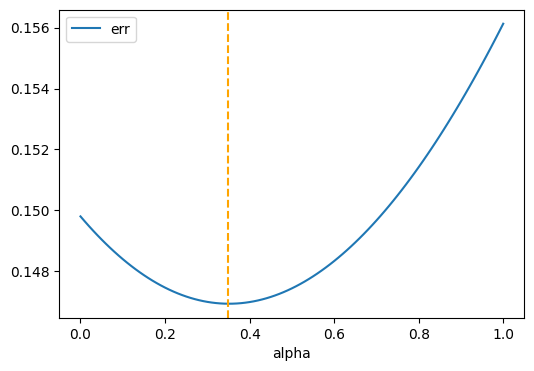

In [10]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

df_err = pandas.DataFrame(tmp).set_index(keys=["alpha"])

df_err.plot(ax=ax)
ax.axvline(x=df_err.sort_values(by=["err"]).index[0], ls='--', color='orange')

In [11]:
pandas.DataFrame(tmp).set_index(keys=["alpha"]).sort_values(by=["err"]).head(10)

,err
alpha,
0.35,0.146925
0.36,0.146927
0.34,0.146928
0.37,0.146933
0.33,0.146936
0.38,0.146944
0.32,0.146948
0.39,0.146960
0.31,0.146965


So taking a weighted average across models could lead to a better prediction.

### Stacking Regressor - No pass through of features

Use `StackingRegressor` to combine outputs from different models, do not pass through features

In [12]:
stacked_regressor = StackingRegressor(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=Lasso(),
    passthrough=False,
    cv=5
)

In [13]:
m = stacked_regressor.fit(X_train, y_train)

In [14]:
numpy.sqrt(mean_squared_log_error(y_train, m.predict(X_train)))

0.03969524436974401

In [15]:
numpy.sqrt(mean_squared_log_error(y_test, m.predict(X_test)))

0.143003531407995

In [16]:
stacked_regressor.final_estimator_.coef_

array([ 0.43967252,  1.08340918, -0.34672734, -0.29120475,  0.15518536])

In [17]:
stacked_regressor.final_estimator_.intercept_

-5327.160146152193

### Stacking Regressor - Pass through features

To pass through features, we need to define feature preprocessing. Creating a single pipeline is not straightforward (see [here](https://github.com/scikit-learn/scikit-learn/issues/16473)) - so we define the procedure manually

In [18]:
class StackingRegressorCustom(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        
        self.base_models_ = [list() for x in self.base_models.keys()]
        self.meta_model_ = clone(self.meta_model)
        
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=12345)

        # Train cloned base models to create out-of-fold predictions
        out_of_fold_predictions = numpy.zeros((X.shape[0], len(self.base_models)))       
        
        for i, model in enumerate(self.base_models.values()):
            for train_idx, holdout_idx in kfold.split(X, y):

                m = clone(model)
                self.base_models_[i].append(m)
                m.fit(X.iloc[train_idx], y.iloc[train_idx])
                y_pred = m.predict(X.iloc[holdout_idx])
                out_of_fold_predictions[holdout_idx, i] = y_pred

        # Transform to DataFrame
        df_oos_pred = pandas.DataFrame(
            out_of_fold_predictions,
            columns=list(self.base_models.keys()),
            index=X.index
        )

        # Join onto original training dataset
        X_train_new = X.join(df_oos_pred)

        # Now train the cloned meta-model using the out-of-fold
        # predictions as new features in the training dataset
        self.meta_model_.fit(X_train_new, y)
        
        return self
   
    def predict(self, X):

        # Calculate predictions for all base models
        preds = numpy.column_stack([
            numpy.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])

        df_preds = pandas.DataFrame(
            preds,
            columns=list(self.base_models.keys()),
            index=X.index
        )

        # Append onto features X
        X_meta = X.join(df_preds)
        
        # Predict using meta model
        return self.meta_model_.predict(X_meta)

In [19]:
stacked_regressor = StackingRegressorCustom(
    base_models=models,
    meta_model=clone(models["GradientBoostingRegressor"]),
    n_folds=5
)

In [20]:
stacked_regressor = stacked_regressor.fit(X_train, y_train)

In [21]:
numpy.sqrt(mean_squared_log_error(y_train, stacked_regressor.predict(X_train)))

0.04298946737777465

In [22]:
numpy.sqrt(mean_squared_log_error(y_test, stacked_regressor.predict(X_test)))

0.13512204744239695

### Train on entire dataset

In [23]:
X_full = pandas.concat([X_train, X_test])
y_full = pandas.concat([y_train, y_test])

In [24]:
X_full.shape

(1460, 79)

In [25]:
y_full.shape

(1460,)

In [26]:
model_full = stacked_regressor.fit(X_full, y_full)

In [27]:
# In sample
numpy.sqrt(mean_squared_log_error(y_full, model_full.predict(X_full)))

0.043948347697895504